# パッケージインストール

In [1]:
!pip install -q onnxruntime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 30.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 3.0 MB/s eta 0:00:00


# 重みダウンロード

In [2]:
# !git clone https://github.com/SkyTNT/anime-segmentation

In [3]:
!wget https://huggingface.co/skytnt/anime-seg/resolve/main/isnetis.onnx -O isnetis.onnx -q

# サンプル画像ダウンロード

In [4]:
!wget https://raw.githubusercontent.com/Kazuhito00/CartoonSegmentationOnnx-Colaboratory-Sample/main/docs/test.webp -O test.webp -q

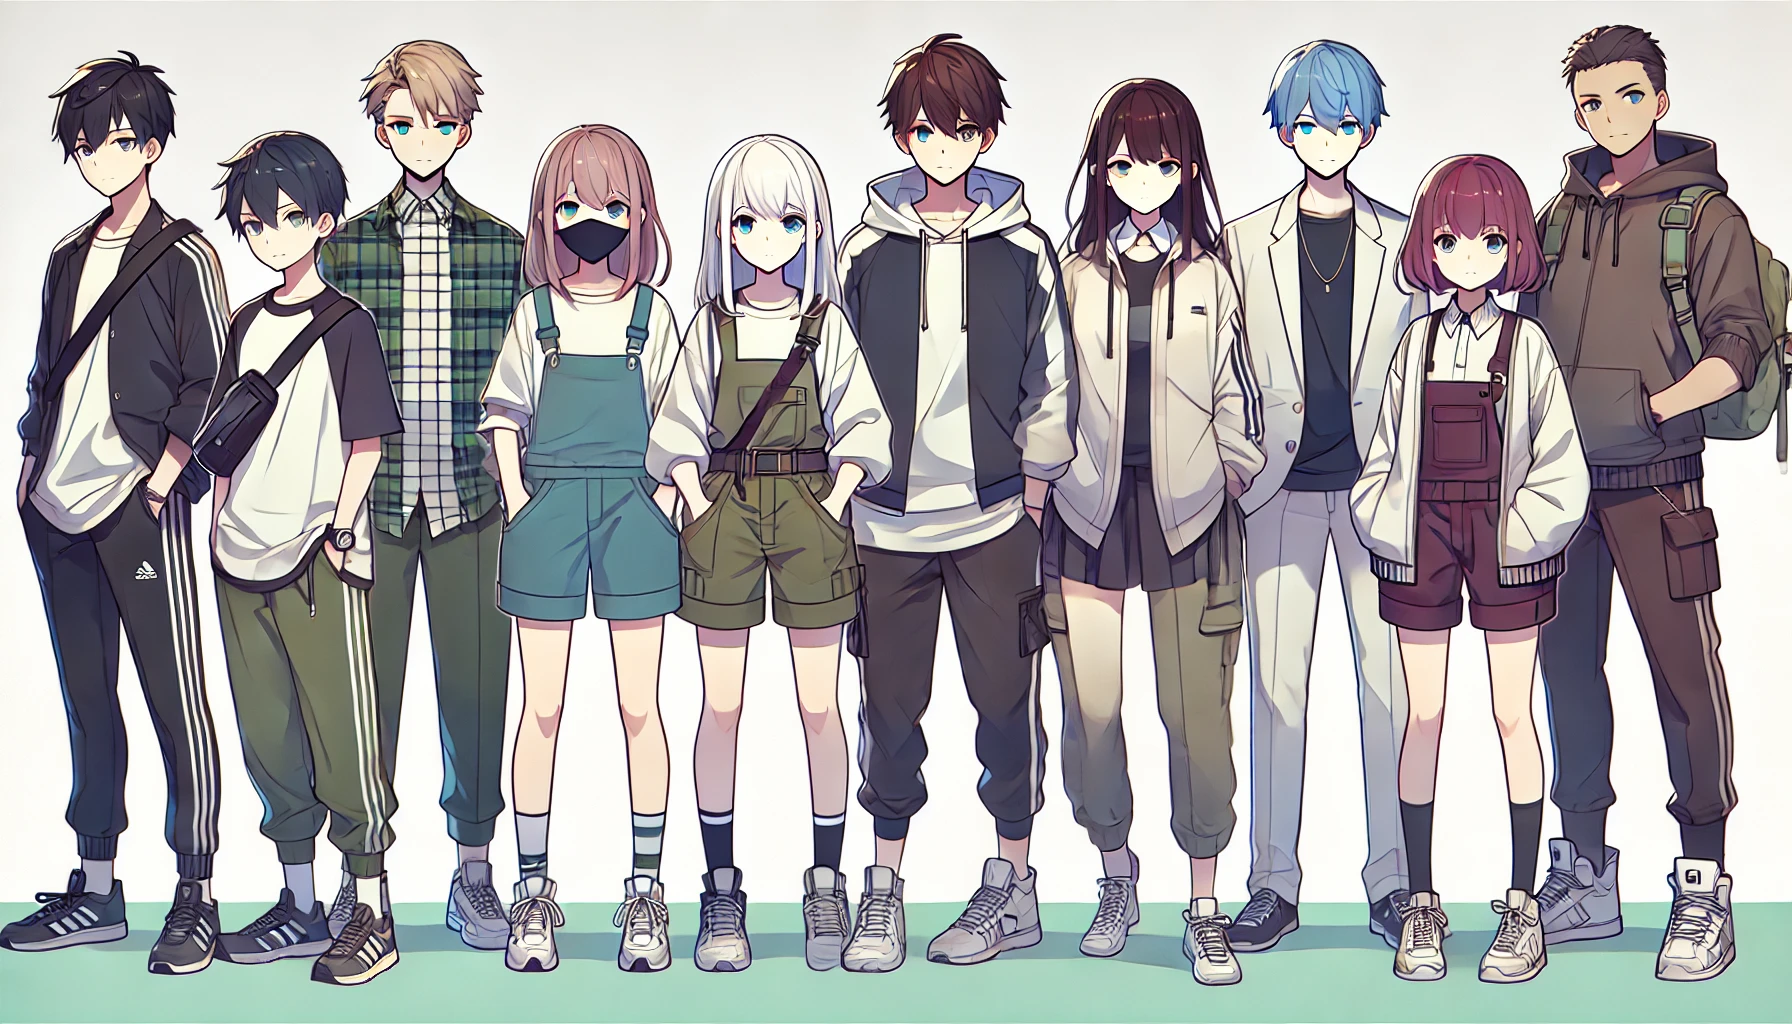

In [5]:
import cv2
from google.colab.patches import cv2_imshow

image = cv2.imread("test.webp")
cv2_imshow(image)

# 推論テスト

In [6]:
import copy

import cv2
import numpy as np

def run_inference(onnx_session, input_image, s=1024):
    input_image_ = copy.deepcopy(input_image)

    # 画像の前処理 (正規化とリサイズ)
    input_image_ = (input_image_ / 255).astype(np.float32)
    h, w = h0, w0 = input_image_.shape[:-1]
    h, w = (s, int(s * w / h)) if h > w else (int(s * h / w), s)
    ph, pw = s - h, s - w

    # 正方形の入力画像を作成
    temp_input_image = np.zeros([s, s, 3], dtype=np.float32)
    temp_input_image[ph // 2:ph // 2 + h, pw // 2:pw // 2 + w] = cv2.resize(input_image_, (w, h))

    # チャネルの次元を (C, H, W) に変換し、バッチ次元を追加
    temp_input_image = np.transpose(temp_input_image, (2, 0, 1))
    temp_input_image = temp_input_image[np.newaxis, :]  # バッチ次元を追加

    # 推論
    input_name = onnx_session.get_inputs()[0].name
    pred = onnx_session.run(None, {input_name: temp_input_image})[0]

    # 後処理
    pred = pred[0][0]
    pred = pred[ph // 2:ph // 2 + h, pw // 2:pw // 2 + w]  # パディング部分を削除
    pred = cv2.resize(pred, (w0, h0))[:, :, np.newaxis]  # 元のサイズにリサイズ

    return pred

In [7]:
import onnxruntime

# モデルロード
onnx_session = onnxruntime.InferenceSession(
    'isnetis.onnx',
    providers=[
        'CUDAExecutionProvider',
        'CPUExecutionProvider',
    ],
)

/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:69: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


In [10]:
# ウォームアップ
_ = run_inference(onnx_session, image)

In [11]:
%%time

mask = run_inference(onnx_session, image)

CPU times: user 6.58 s, sys: 56.7 ms, total: 6.64 s
Wall time: 6.69 s


# 結果確認

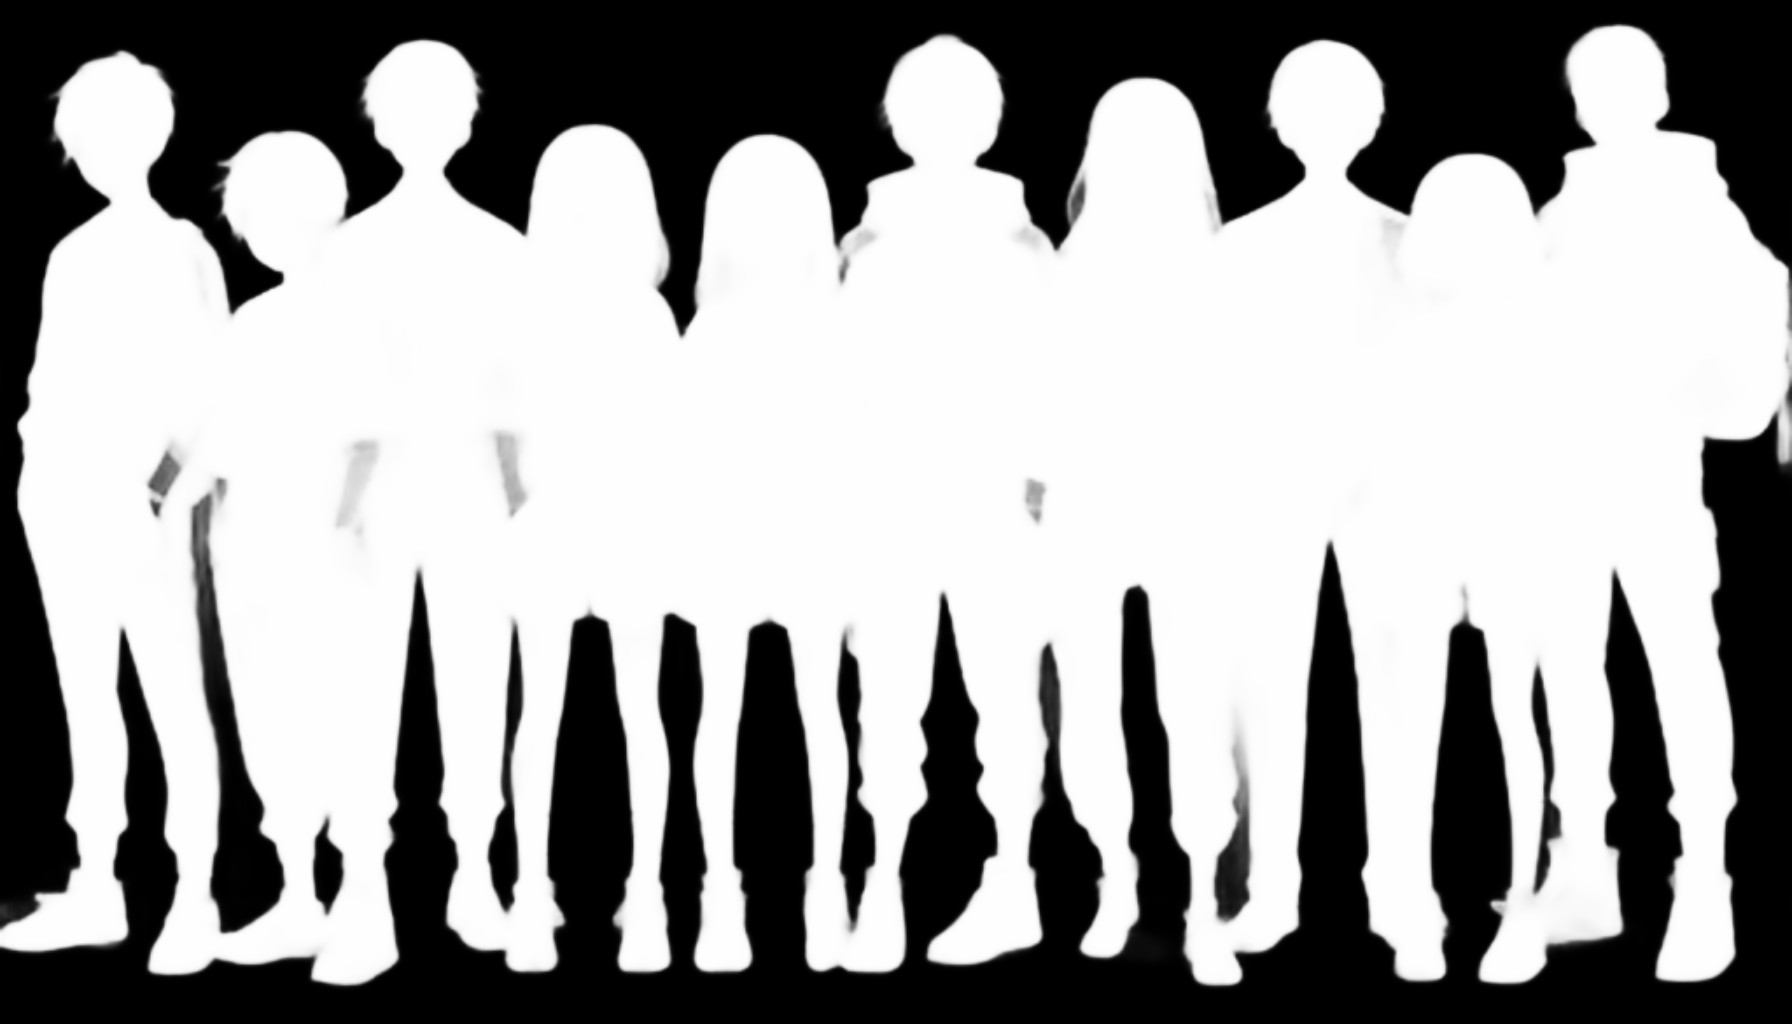

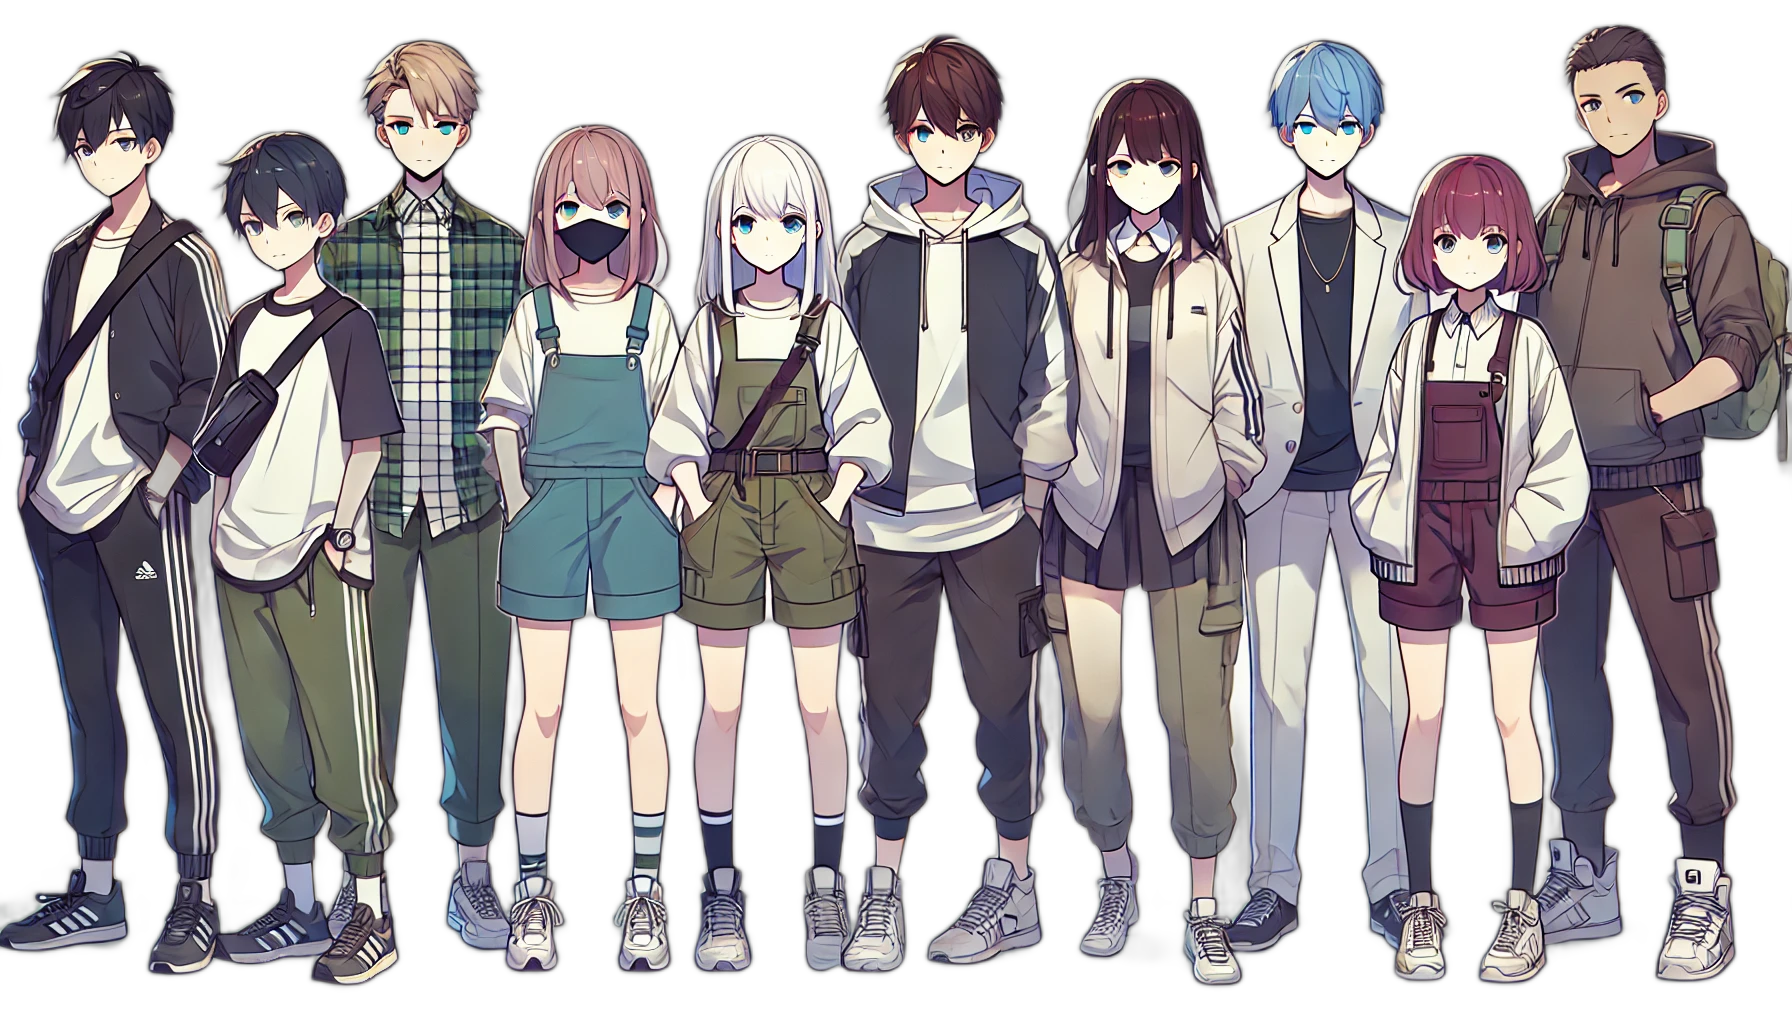

In [13]:
debug_image = np.concatenate((mask * image + 1 - mask, mask * 255), axis=2).astype(np.uint8)
cv2_imshow(mask*255)
cv2_imshow(debug_image)